## Online-learning


In a typical supervised learning problem we have a fixed volume of training data with which to fit a model. Imagine, instead, we have a constant stream of data. Now, we could dip into this stream and take a sample from which to build a static model. But let's also imagine that, from time to time, there is a change in the observations arriving. Ideally we want a model that automatically adapts to changes in the data stream and updates its own parameters. This is sometimes called "online learning."

### The data
We imagine a continuous stream of data. For today's artificial example, we have 300 sequential observations in (x,y) pairs. The first 100 observations shows a certain linear relationship between x & y. Then something happens and the next 100 observations are different: x and y are now related in a different way. Finally, there is another change resulting in 100 more observations that are different again:

Populating the interactive namespace from numpy and matplotlib


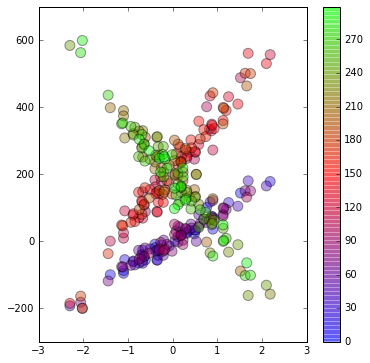

In [1]:
# prepare python
%pylab inline
import numpy as np
from sklearn.datasets import make_regression
from mpl_toolkits.mplot3d import Axes3D
 
# Create three populations of 100 observations each
pop1_X, pop1_Y = make_regression(n_samples=100, noise=20, n_informative=1, n_features=1, random_state=1, bias=0) 
pop2_X, pop2_Y = make_regression(n_samples=100, noise=20, n_informative=1, n_features=1, random_state=1, bias=100) 
pop3_X, pop3_Y = make_regression(n_samples=100, noise=20, n_informative=1, n_features=1, random_state=1, bias=-100) 
 
# Stack them together
pop_X = np.concatenate((pop1_X,pop2_X,pop3_X))
pop_Y = np.concatenate((pop1_Y, 2 * pop2_Y, -2 * pop3_Y))
 
# Add intercept to X
pop_X = append(np.vstack(np.ones(len(pop_X))),pop_X,1)
 
# convert Y's into proper column vectors
pop_Y = np.vstack(pop_Y)
 
### plot
mycmap = cm.brg 
fig = plt.figure(figsize(6,6), dpi=1600) 
plt.subplots_adjust(hspace=.5)            
gridsize = (1,1)
ax0 = plt.subplot2grid(gridsize,(0,0))
sc = ax0.scatter(pop_X[:,1], pop_Y, s=100, alpha=.4, c=range(len(pop_X)), cmap=mycmap) 
plt.colorbar(sc, ax=ax0)


The blue, red and green observations each show different linear relationships between xx and yy: we might say that are draw from different populations. We want our model to automatically detect and adapt to each population as it appears in our data stream. That is, we want it to fit a line through the blue observations. Then, when the red observations start arriving, we want our line to adjust to pass through them. Finally, the line should adapt to the green observations when they hit the data stream.

Before we can tackle that, let's do a quick refresher on gradient descent:

## Gradient Descent

Gradient descent is a method of searching for model parameters which result in the best fitting model. There are many, many search algorithms, but this one is quick and efficient for many sorts of supervised learning models.

Let's take the simplest of simple regression models for predicting y: y=α+βx. Our model has two parameters - α, the intercept, and β, the coefficient for x - and we want to find the values which produce the best fitting regression line.

How do we know whether one model fits better than another? We calculate the error or cost of the predictions. For regression models, the most common cost function is mean squared error:





The cost function quantifies the error for any given α and β. Since it is squared, it will take the form of an inverted parabola. Let's visualise what it looks like for the first 100 observations in our dataset:

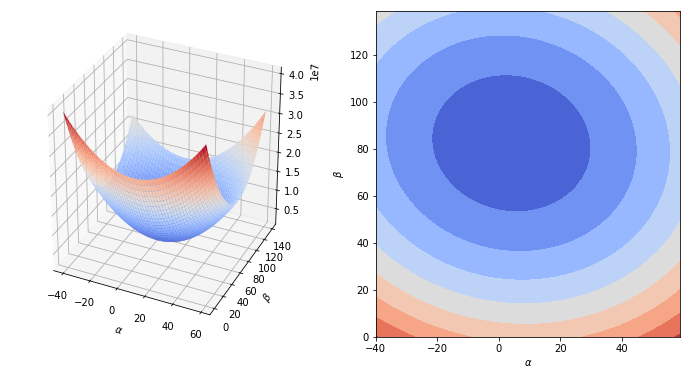

In [2]:
## Specify prediction function
def fx(theta, X):
    return np.dot(X, theta)
 
## Specify cost function
def fcost(theta, X, y):
    return (1./2*len(X)) * sum((np.vstack(fx(theta,X)) - y)**2)
 
## Specify a range of possible a and b
a_possible = asarray(range(-40,60,1))
 
# theta1 could be the same:
b_possible = asarray(range(0,140,1))
 
# create meshgrid
X, Y = np.meshgrid(a_possible, b_possible)
 
# calculate cost of each combination of a,b
z = dstack([X.flatten(),Y.flatten()])[0]
j = np.array([(fcost(z[i], pop_X[0:100], pop_Y[0:100])) for i in range(len(z))])
J = j.reshape(shape(X))
 
## plot
fig = plt.figure(figsize(12,6))
plt.subplots_adjust(hspace=.5)            
 
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, J, cmap=cm.coolwarm)
ax.view_init(azim=295, elev=30)
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$\\beta$')
 
ax = fig.add_subplot(122)
ax.contourf(X, Y, J, cmap=cm.coolwarm)
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$\\beta$')

At the bottom (or minima) or the parabola is the lowest possible cost. We want to find the α and β which correspond to that minima.

The idea of gradient descent is to take small steps down the surface of the parabola until we reach the bottom. The gradient of gradient descent is the gradient of the cost function, which we find by taking the partial derivative of the cost function with respect to the model coefficients. Steps:

1. For the current value of α and β, calculate the cost and the gradient of the cost function at that point

3. Update the values of α and β by taking a small step towards the minima. This means, subtracting some fraction of the gradient from them. The formulae are:

Steps 1 & 2 are repeated until one is satisfied that the model is not getting any better (cost isn't decreasing much with each step).
                                                                                     
                                                                           
 The learning rate parameter γ controls the size of the steps. This is a parameter which we must choose. There is some art in choosing a good learning rate, for if it is too large or too small then it can prevent the algorithm from finding the minima.
 
 
 
 Let's briefly see it in action - we'll just do five steps. Then we can move on to talk about how we can use this technique for online learning.

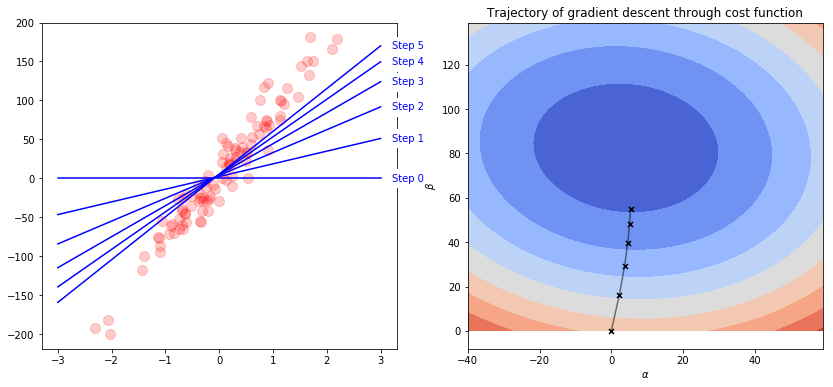

In [3]:
## parameters
n_learning_rate = 0.25     
 
## Specify prediction function
def fx(theta, X):
    return np.dot(X, theta)
 
## Specify cost function
def fcost(theta, X, y):
    return (1./2*len(X)) * sum((np.vstack(fx(theta,X)) - y)**2)
 
## Specify function to calculate gradient at a given theta
def gradient(theta, X, y):
    grad_theta = (1./len(X)) * sum(np.multiply(np.vstack(fx(theta, X)) - y, X),axis=0) 
    return grad_theta
 
## Specify starting values for alpha and beta
theta = [0,0]
 
## Run 5 iterations of batch gradient descent, recording model parameters and costs
arraytheta = np.array(theta)
arraycost = np.array(fcost(theta, pop_X[0:100], pop_Y[0:100]))
 
for i in range(5):
    theta = theta - n_learning_rate * gradient(theta, pop_X[0:100], pop_Y[0:100])
    arraytheta = np.vstack([arraytheta, theta])
 
 
### Plot
fig = plt.figure(figsize(14,6))
plt.subplots_adjust(hspace=.5)            
gridsize = (1,2)
ax0 = plt.subplot2grid(gridsize,(0,0))
ax0.scatter(pop_X[0:100,1], pop_Y[0:100], s=100, alpha=.2, c='red')
 
xrangex = np.linspace(-3,3,50)
for i in range(0, len(arraytheta)):
    yrangey = arraytheta[i,0] + arraytheta[i,1] * xrangex
    ax0.plot(xrangex, yrangey, c='blue') 
    ax0.text(3.5, arraytheta[i,0] + arraytheta[i,1] * 3, "Step " + str(i), color='blue', 
             ha="center", va="center", bbox = dict(ec='1',fc='1'))
 
# plot movement through costed parameter space
ax1 = plt.subplot2grid(gridsize,(0,1))
ax1.contourf(X, Y, J, cmap=cm.coolwarm)
ax1.set_xlabel('$\\alpha$')
ax1.set_ylabel('$\\beta$')
ax1.set_title('Trajectory of gradient descent through cost function');
for i in arraytheta:
    plt.scatter(i[0],i[1],marker='x',color='black',s=25)
plt.plot(arraytheta[:,0],arraytheta[:,1], '-', c='black', alpha=0.5)

Left chart: see how the regression line is gradually finding its way to fitting the shape of the data

Right chart: the gradient descent algorithm moves toward lower cost values for α and β.

## Stochastic gradient descent for adaptive modelling

The gradient descent we've just done is called batch gradient descent. That's because at each step we calculate the cost across the entire training dataset. This isn't going to work for online learning, since we don't have a finite training dataset - we have a continuous stream of observations.

The solution is to run an update step with every passing observation. This is called stochastic gradient descent. It looks like this:

In [4]:
## parameters
n_learning_rate = 0.1             # learning rate paramenter
 
## Specify prediction function
def fx(theta, X):
    return np.dot(X, theta)
 
## specify cost function
def fcost(theta, X, y):
    return (1./2*len(X)) * sum((fx(theta,X) - y)**2)   
 
## specify function to calculate gradient at a given theta - returns a vector of length(theta)
def gradient(theta, X, y):
    grad_theta = (1./len(X)) * np.multiply((fx(theta, X)) - y, X) 
    return grad_theta
 
### DO stochastic gradient descent
# starting values for alpha & beta
theta = [0,0]
 
# record starting theta & cost
arraytheta = np.array([theta])
arraycost = np.array([])
 
# feed data through and update theta; capture cost and theta history
for i in range(0, len(pop_X)):
    # calculate cost for theta on current point
    cost = fcost(theta, pop_X[i], pop_Y[i])
    arraycost = np.append(arraycost, cost)
    # update theta with gradient descent
    theta = theta - n_learning_rate * gradient(theta, pop_X[i], pop_Y[i])
    arraytheta = np.vstack([arraytheta, theta])
 
     
#### plot 
fig = plt.figure(figsize(12,6), dpi=1600) 
plt.subplot(121)
plt.scatter(pop_X[:,1], pop_Y, s=100, alpha=.2, c=range(len(pop_X)), cmap=mycmap)   
 
# plot line for every 20th theta onto chart
n=len(pop_X)
colnums = [int(i) for i in np.linspace(0,256,n)]
lineColours = mycmap(colnums)
 
xrangex = np.linspace(-3,3,50)
for i in range(0, len(pop_X), 20):
    yrangey = arraytheta[i,0] + arraytheta[i,1] * xrangex
    plt.plot(xrangex, yrangey, c=lineColours[i], label = "Step " + str(i)) 
plt.legend(bbox_to_anchor=(1.05,1),loc=2)

Remember that our dataset contains 100 blue observations then 100 red observations then 100 green observations, with each colour signifying a different population that has a different relationship between x and y. See that the regression line gradually adjusts as the populations change. The coefficients α and β are updated after each observation using the gradient descent algorithm.

The speed of adaptation is parametrised by the **learning rate**. The choice of learning rate is quite important. We are allowing every passing observation to adjust our model fit. If we make the learning rate too large, then the model will quickly adapt to changes in populations but it will also be susceptible to noise and outliers. At worst, it could sway about erratically. If we make the learning rate too small, then our model will adapt slowly to any changes in population. This is a classic bias/variance tradeoff dilemma.

It is interesting to plot the error (cost). **prediction error** is plotted in the following chart. As one expects, the error spikes at points 100 and 200: these are the points at which the population of arriving observations suddenly changes. Also see the error rapidly decline as the gradient descent mechanism adapts the regression model to the new circumstances:

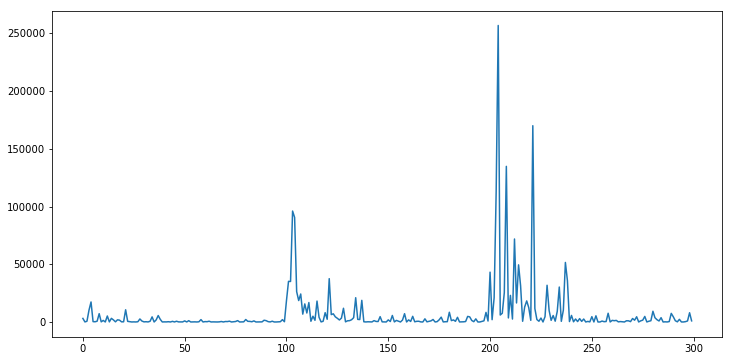

In [5]:
plt.plot(arraycost)